In [179]:
# Load libraries 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.optimize import curve_fit
import imageio.v2 as imageio
from skimage.feature import peak_local_max
import os
from tkinter import filedialog
from tkinter import Tk


In [172]:
# Gaussian 2D function
def gaussian_2d(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

# Fit Gaussian 2D for each peak in the image
def fit_gaussian_2d(image_data, peaks, localsize, sigma_x=10, sigma_y=10):
    x = np.linspace(0, image_data.shape[1] - 1, image_data.shape[1])
    y = np.linspace(0, image_data.shape[0] - 1, image_data.shape[0])
    x, y = np.meshgrid(x, y)

    fitted_gaussians = []

    for peak in peaks:
        amplitude = image_data[peak[0], peak[1]]
        xo, yo = peak[::-1]
        image_data_b = np.copy(image_data) 
        image_mean = np.mean(image_data)
        image_data_b[image_data_b > image_mean] = image_mean
        image_data_b[peak[0]-localsize:peak[0]+localsize, peak[1]-localsize:peak[1]+localsize] = image_data[peak[0]-localsize:peak[0]+localsize, peak[1]-localsize:peak[1]+localsize]
        initial_guess = (amplitude, xo, yo, sigma_x, sigma_y, 0, 0)
        popt, _ = curve_fit(gaussian_2d, (x, y), image_data.ravel(), p0=initial_guess)
        fitted_gaussians.append(popt)

    return fitted_gaussians


In [188]:
# Function for plot
def plot_original_and_fitted(image_data, fitted_gaussians, zoom, showplot, saveplot, folder_path, filename):
    x = np.linspace(0, image_data.shape[1] - 1, image_data.shape[1])
    y = np.linspace(0, image_data.shape[0] - 1, image_data.shape[0])
    x, y = np.meshgrid(x, y)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(image_data, cmap='jet')
    ax[0].set_title('Original Image')

    fitted_data = np.zeros_like(image_data, dtype=float)
    fitted_data_magnified = np.zeros_like(image_data, dtype=float)

    for popt in fitted_gaussians:
        fitted_data += gaussian_2d((x, y), *popt).reshape(image_data.shape)
        
        # Draw ellipses using scatter plot
        fwhm_x = 2.355  * popt[3] * 1.8
        fwhm_y = 2.355  * popt[4] * 1.8
        theta = np.linspace(-np.pi, np.pi, 100)
        ellipse_x = popt[1] + fwhm_x / 2 * np.cos(theta) * np.cos(-popt[5]) - fwhm_y / 2 * np.sin(theta) * np.sin(-popt[5])
        ellipse_y = popt[2] + fwhm_x / 2 * np.cos(theta) * np.sin(-popt[5]) + fwhm_y / 2 * np.sin(theta) * np.cos(-popt[5])
        ax[1].plot(ellipse_x, ellipse_y, 'w--', lw=1)
        
        # Display FWHM and maximum value
        max_value = popt[0]
        ax[1].text(popt[1], popt[2] + fwhm_y,
                   f"({popt[1]:.2f}, {popt[2]:.2f})\nFWHM_X: {abs(fwhm_x):.2f}\nFWHM_Y: {abs(fwhm_y):.2f}\nMax: {max_value:.2f}\nTheta: {popt[6]:.2f}",
                   color='white', fontsize=8, ha='center', va='center')

    # Create magnified fitted data
    for popt in fitted_gaussians:
        magnified_popt = list(popt)
        magnified_popt[3] *= zoom  # Magnify sigma_x
        magnified_popt[4] *= zoom  # Magnify sigma_y
        fitted_data_magnified += gaussian_2d((x, y), *magnified_popt).reshape(image_data.shape)

    ax[1].imshow(fitted_data, cmap='jet')
    ax[1].set_title('Fitted 2D Gaussians')

    ax[2].imshow(fitted_data_magnified, cmap='jet')
    ax[2].set_title(f"Magnified Fitted 2D Gaussians (x{zoom})")
        
    if saveplot:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')):
            image_path = os.path.join(folder_path, filename)
            output_image_path = os.path.join(folder_path, f"{os.path.splitext(filename)[0]}_analysis.tif")
            plt.savefig(output_image_path)            
        
    if showplot:
        plt.show()
        
    plt.close()
    return



In [189]:
def select_image_file():
    root = tk.Tk()
    root.withdraw()
    image_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.bmp;*.tif;*.tiff")])
    return image_path

In [190]:
def image_process(image_path, zoom, showplot, saveplot, folder_path, filename):
    if image_path:
        image_data = imageio.imread(image_path)

        # Detect local maxima
        peaks = peak_local_max(image_data, min_distance=10, threshold_abs=10, exclude_border=True)

        # Perform 2D Gaussian fit for each local maximum
        fitted_gaussians = fit_gaussian_2d(image_data, peaks, 25)

        # Plot original and fitted images
        plot_original_and_fitted(image_data, fitted_gaussians, zoom, showplot, saveplot, folder_path, filename)
    else:
        print("No image file selected.")

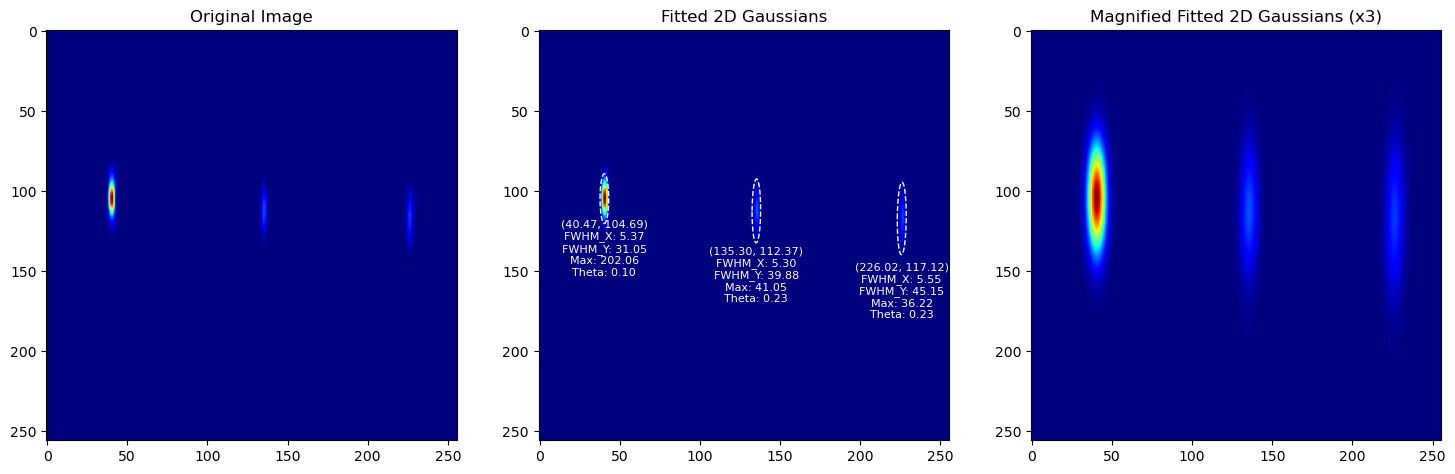

In [191]:
image_path = select_image_file()
image_process(image_path, 3, True, False, 0, 0)

In [192]:
def process_images_in_folder(folder_path, showplot, saveplot):
    if not folder_path:
        print("No folder selected. Exiting.")
        return -1

    # Process all images in the selected folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')) and not filename.lower().endswith('_analysis.tif'):
            image_path = os.path.join(folder_path, filename)
            image_data = imageio.imread(image_path)
            if image_data is not None:
                image_process(image_path, 3, showplot, saveplot, folder_path, filename)
                
    return 0


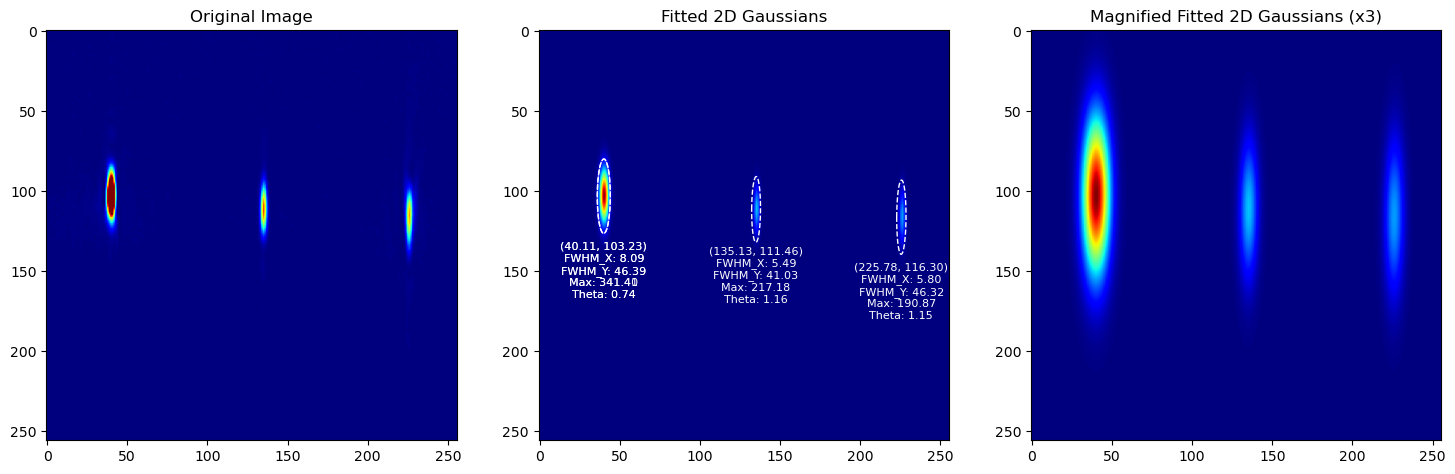

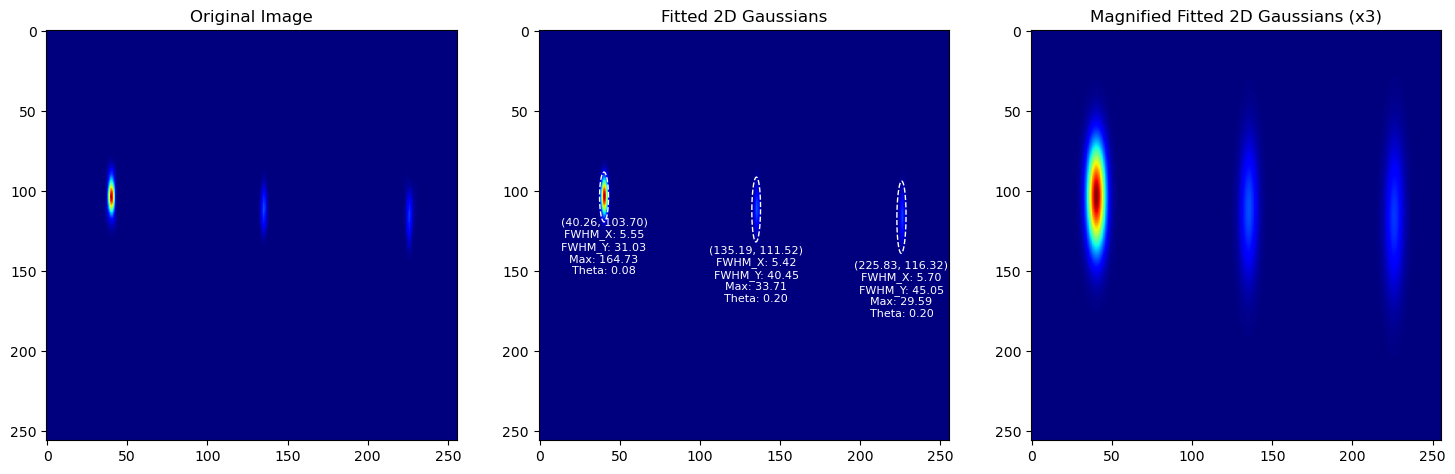

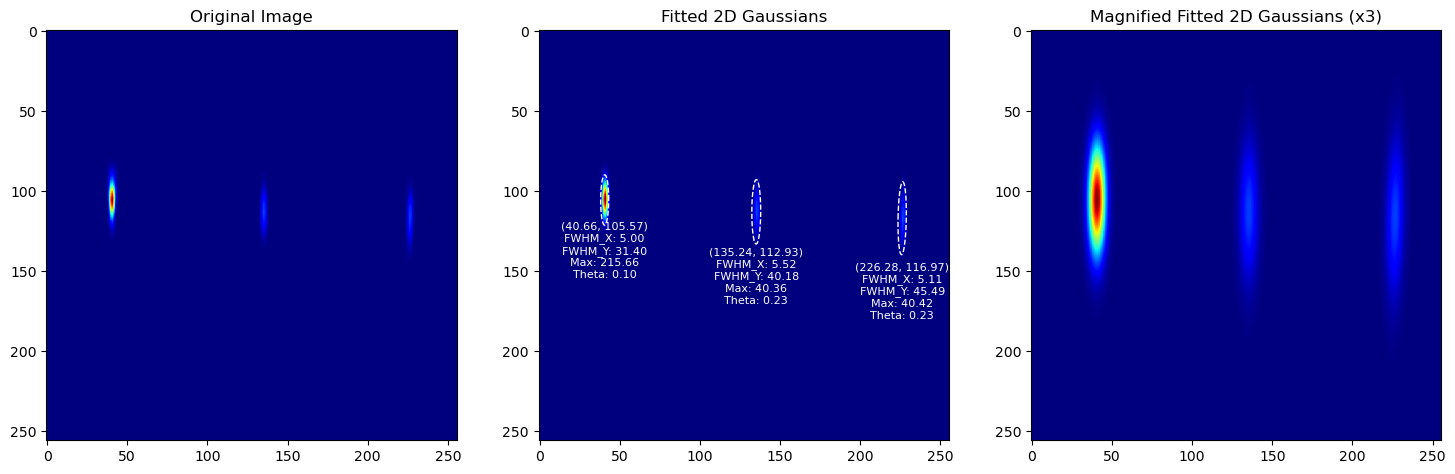

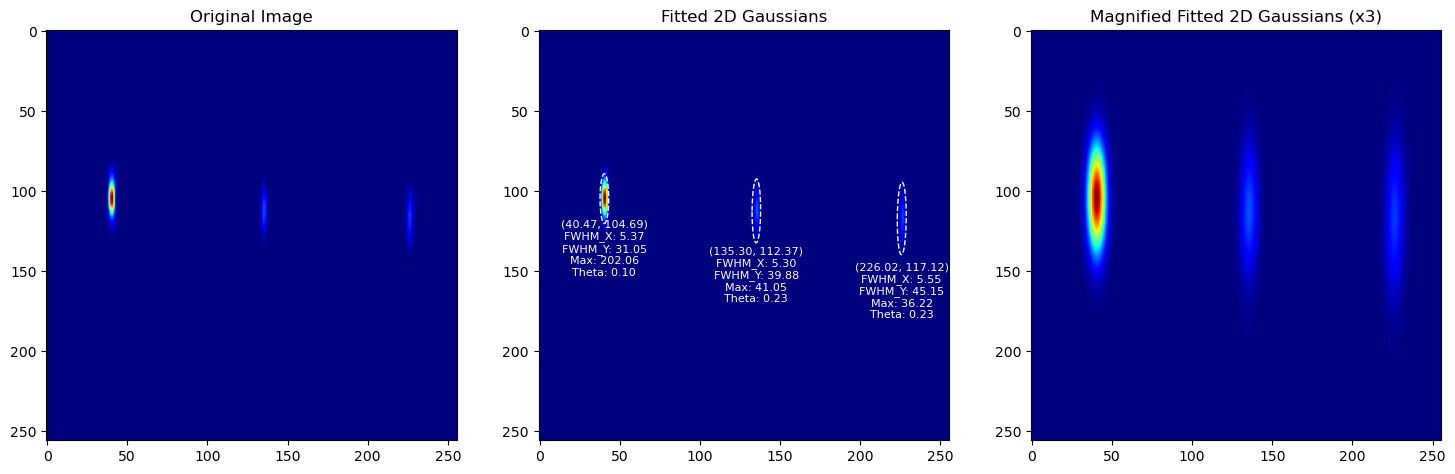

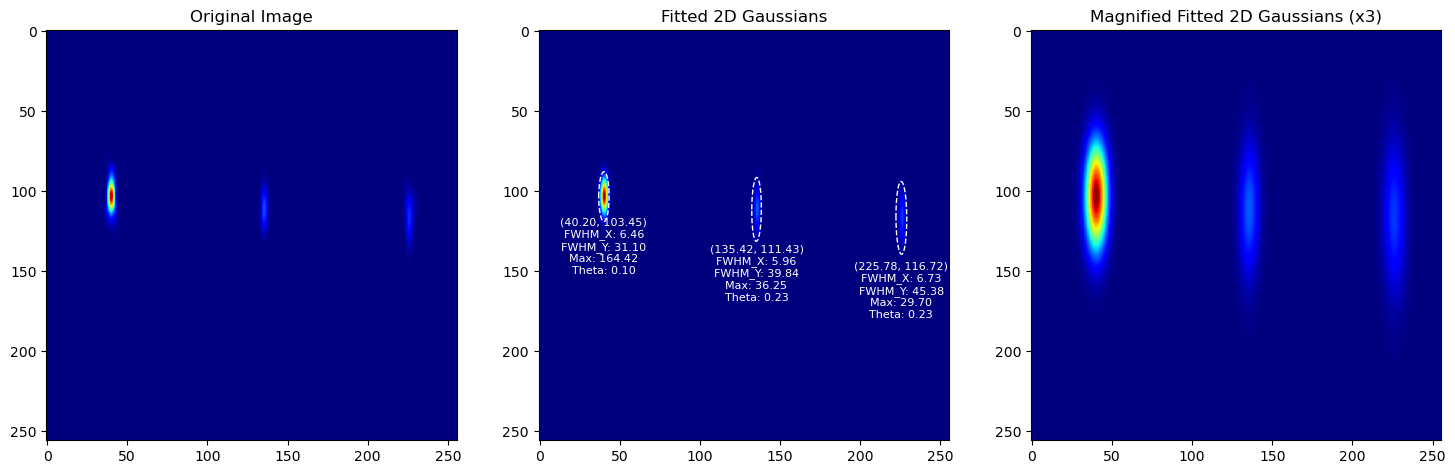

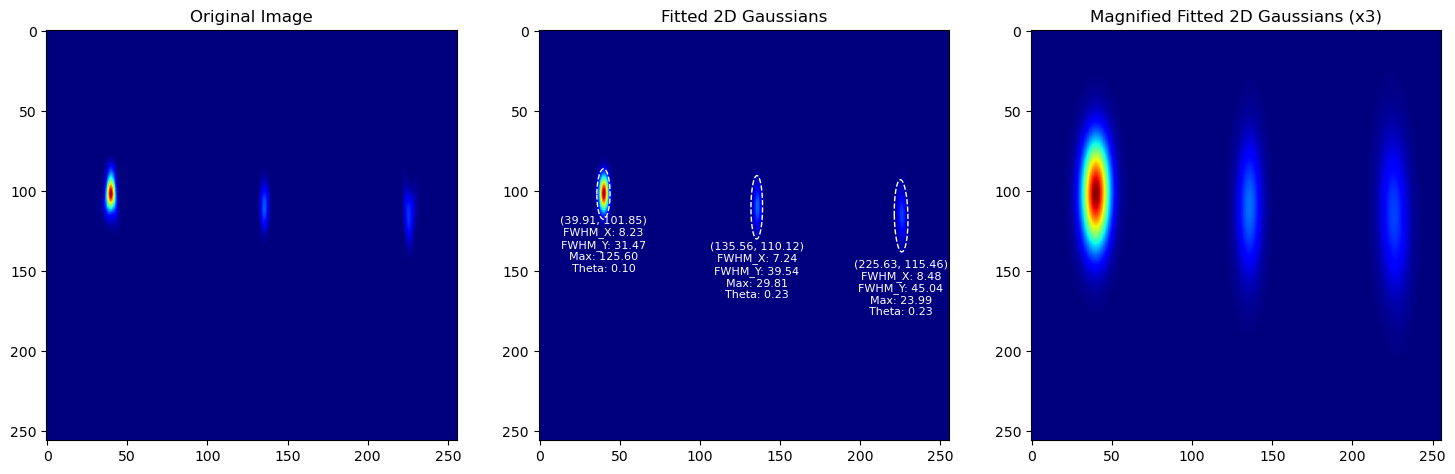

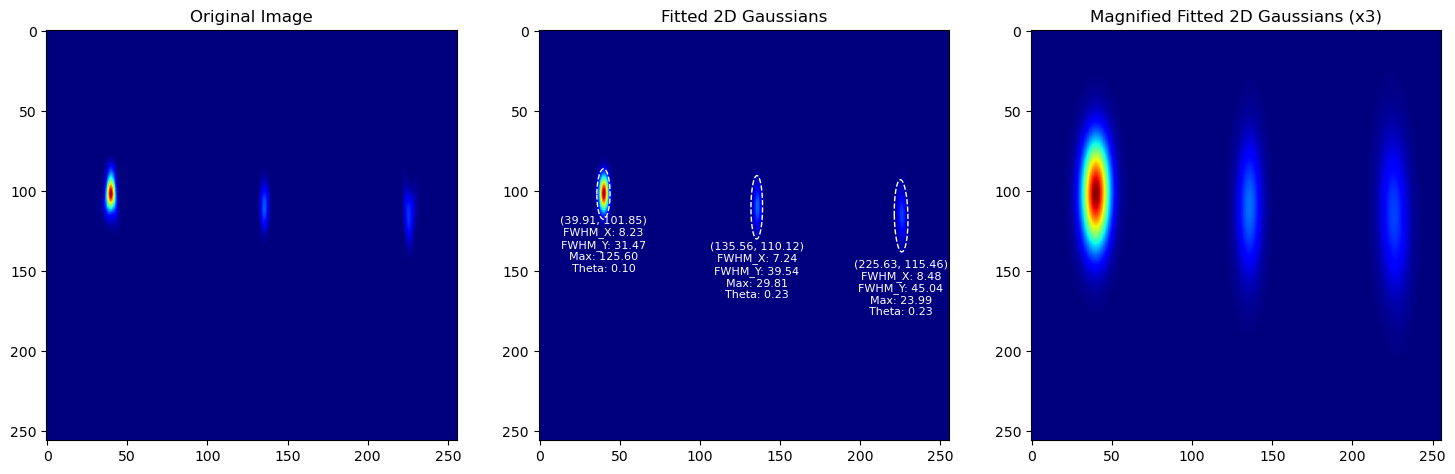

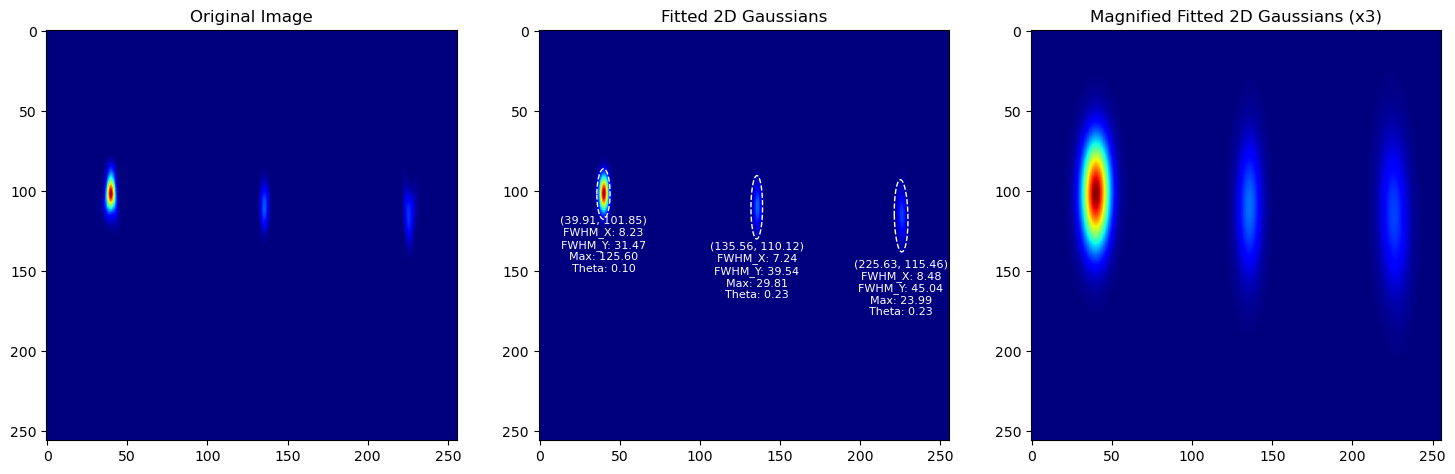

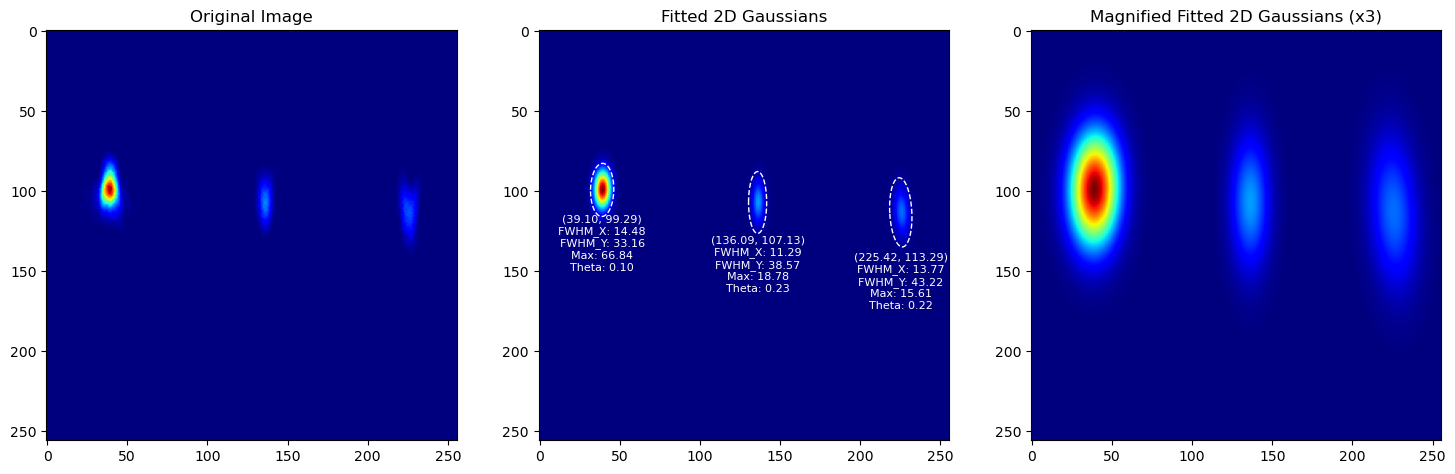

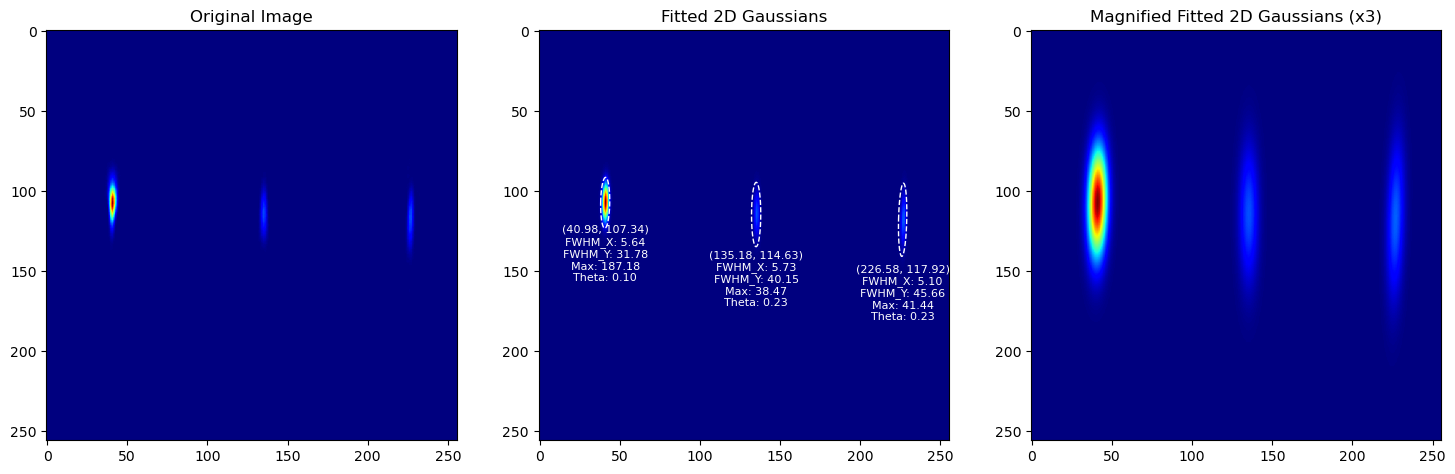

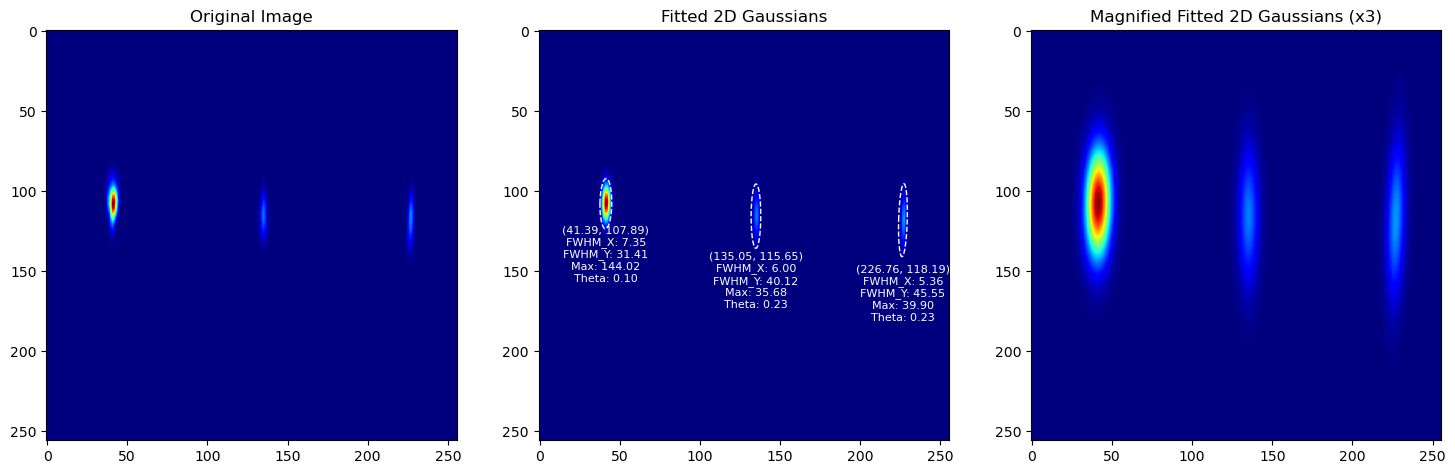

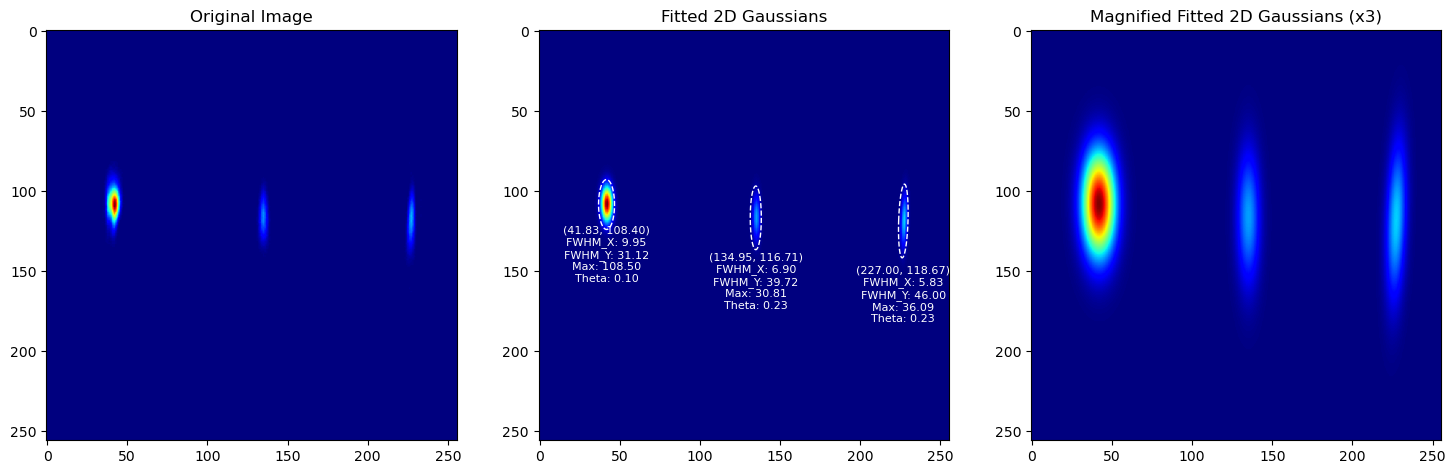

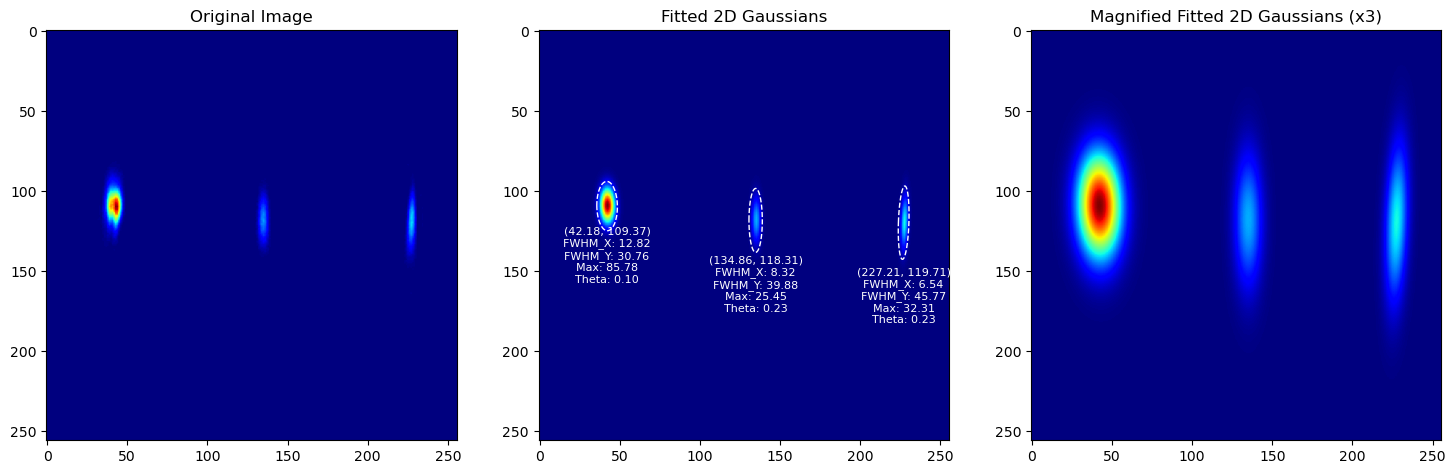

0

In [193]:
# Select a folder with a GUI
root = Tk()
root.withdraw()  # Hide the main window
folder_path = filedialog.askdirectory(title="Select a folder containing images")
root.destroy()

# Process images in the selected folder
process_images_in_folder(folder_path, True, True)